# 範例 : 計程車費率預測
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

# [作業目標]
- 試著模仿範例寫法, 使用程車費率預測競賽練習時間欄位處理

# [作業重點]
- 新增星期幾(day of week)與第幾周(week of year)這兩項特徵, 觀察有什麼影響 (In[4], Out[4], In[5], Out[5])
- 新增加上年週期與周周期特徵 , 觀察有什麼影響 (In[8], Out[8], In[9], Out[9]) 

#### [參考資料]
- [PYTHON-基礎-時間日期處理小結](http://www.wklken.me/posts/2015/03/03/python-base-datetime.html)
> 這裡主要是摘錄一些 datetime 套件的時間欄位操作方式，使用這一個套件就能將各式時間格式轉成統一的時間物件，方便做轉換與特徵工程。
- [datetime — Basic date and time types](https://docs.python.org/3/library/datetime.html)
> 既然要使用 datetime 套件，詳細的內容當然要參考官方的文件囉。除了各種細節的寫法，老師個人最常用到的還是 .strptime(將文字解析成時間物件) 以及 .strftime (轉出時間物件各欄位成文字)，以及右邊這張表(網頁最下方)，其中除了常見的年月日時分秒外，還有 %w(星期幾)，%U(第幾周) 這種方便的轉換函數呢!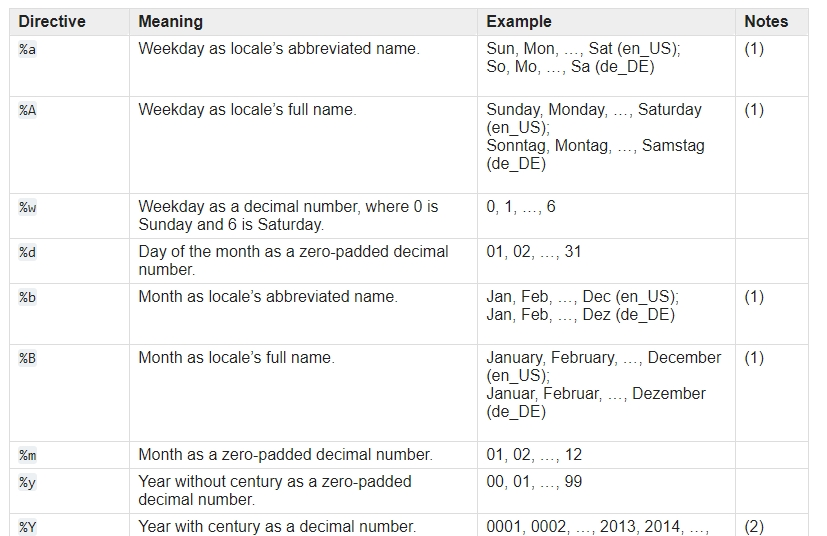

# 週期循環
時間也有週期的概念, 可以用週期合成一些重要的特徵
- 年週期:與春夏秋冬季節溫度相關
- 月週期:與薪⽔水、繳費相關
- 周週期:與周休、消費習慣相關
- 日週期:與⽣生理理時鐘相關

**週期循環特徵**是將時間"循環"特性改成特徵⽅方式, 設計關鍵在於**首尾相接**, 因此我們需要使⽤用 $sin$/$cos$ 等週期函數轉換。常見的週期循環特徵有 - 年週期(季節) / 周期(例假⽇) /日週期(夜與生活作息), 要注意的是**最高與最低點的設置**。
- 年週期(正:冷 / 負:熱): $cos[( \frac{月}{6} + \frac{日}{180})\pi]$
- 周週期(正:精神飽滿 / 負:疲倦): $sin[( \frac{星期幾}{3.5} + \frac{小時}{84})\pi]$
- 日週期(正:精神飽滿 / 負:疲倦)：$sin[( \frac{小時}{12} + \frac{分}{720} + \frac{秒}{43200})\pi]$

*註 : 此處小時是24小時制

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/part2/'
df = pd.read_csv(data_path + 'taxi_data1.csv')

train_Y = df['fare_amount']
df = df.drop(['fare_amount'] , axis=1)
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2011-10-21 23:54:10 UTC,-73.990580,40.761071,-73.981128,40.758634,2
1,2015-02-03 10:42:03 UTC,-73.988403,40.723431,-73.989647,40.741695,1
2,2014-03-16 18:58:58 UTC,-74.015785,40.715110,-74.012029,40.707888,2
3,2009-06-13 16:10:54 UTC,-73.977322,40.787275,-73.958030,40.778838,3
4,2014-06-12 03:25:56 UTC,-73.989683,40.729717,-73.982490,40.761887,3


In [2]:
# 時間特徵分解方式:使用datetime
df['pickup_datetime'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))
df['pickup_year'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')
df['pickup_month'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')
df['pickup_day'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('int64')
df['pickup_hour'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%H')).astype('int64')
df['pickup_minute'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%M')).astype('int64')
df['pickup_second'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%S')).astype('int64')
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56


In [3]:
# 將結果使用線性迴歸 / 梯度提升樹分別看結果
df_temp = df.drop(['pickup_datetime'] , axis=1)
scaler = MinMaxScaler()
train_X = scaler.fit_transform(df_temp)
Linear = LinearRegression()
GDBT = GradientBoostingRegressor()
linear_0 = cross_val_score(Linear, train_X, train_Y, cv=5).mean()
GDBT_0 = cross_val_score(GDBT, train_X, train_Y, cv=5).mean()
print(f'Linear Reg Score : {linear_0}')
print(f'Gradient Boosting Reg Score : {GDBT_0}')

Linear Reg Score : 0.026876871475636888
Gradient Boosting Reg Score : 0.7100332616102726


# 作業1
* 對照範例，試著加入星期幾 (day of week) 與第幾周 (week of year) 這兩項特徵，  
看看結果會比原本只有時間特徵分解的結果更好或更差?
> 變好一點

In [4]:
# 加入星期幾與第幾周兩個特徵
df['pickup_day_of_week'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%w')).astype('int64')
df['pickup_week_of_year'] = df['pickup_datetime'].apply(lambda x: datetime.datetime.strftime(x, '%U')).astype('int64')
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_of_week,pickup_week_of_year
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,5,42
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,2,5
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0,11
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,6,23
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,4,23


In [5]:
# 將結果使用線性迴歸 / 梯度提升樹分別看結果
df_temp = df.drop(['pickup_datetime'] , axis=1)
train_X = scaler.fit_transform(df_temp)
linear_1 = cross_val_score(Linear, train_X, train_Y, cv=5).mean()
GDBT_1 = cross_val_score(GDBT, train_X, train_Y, cv=5).mean()
print(f'Linear Reg Score : {linear_1}')
print(f'Gradient Boosting Reg Score : {linear_1}')

Linear Reg Score : 0.028722639911798065
Gradient Boosting Reg Score : 0.028722639911798065


In [6]:
# 加上"日週期"特徵 (參考講義"週期循環特徵")
import math
df['day_cycle'] = df['pickup_hour']/12 + df['pickup_minute']/720 + df['pickup_second']/43200
df['day_cycle'] = df['day_cycle'].map(lambda x:math.sin(x*math.pi))
df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_of_week,pickup_week_of_year,day_cycle
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,5,42,-0.025450
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,2,5,0.333601
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0,11,-0.967083
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,6,23,-0.888817
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,4,23,0.782427


In [7]:
# 將結果使用線性迴歸 / 梯度提升樹分別看結果
df_temp = df.drop(['pickup_datetime'] , axis=1)
train_X = scaler.fit_transform(df_temp)
linear_2 = cross_val_score(Linear, train_X, train_Y, cv=5).mean()
GDBT_2 = cross_val_score(GDBT, train_X, train_Y, cv=5).mean()
print(f'Linear Reg Score : {linear_2}')
print(f'Gradient Boosting Reg Score : {GDBT_2}')

Linear Reg Score : 0.028234094061828308
Gradient Boosting Reg Score : 0.7109234960978231


# 作業2
* 對照範例的日週期效果，試著參考投影片完成年週期與周週期的特徵 (也可以用你自己想到的方式)，  
看看結果會比範例中的結果更好或更差?
> 加上年週期與周週期, 正確性有顯著的提升。原因須進一步分析

In [8]:
# 加上"年週期"與"周週期"特徵
df['week_cycle'] = df['pickup_day_of_week']/3.5 + df['pickup_hour']/84
df['week_cycle'] = df['week_cycle'].map(lambda x:math.sin(x*math.pi))
df['year_cycle'] = df['pickup_month']/6 + df['pickup_day']/180
df['year_cycle'] = df['year_cycle'].map(lambda x:math.cos(x*math.pi))

df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_of_week,pickup_week_of_year,day_cycle,week_cycle,year_cycle
0,2011-10-21 23:54:10,-73.990580,40.761071,-73.981128,40.758634,2,2011,10,21,23,54,10,5,42,-0.025450,-0.804598,0.777146
1,2015-02-03 10:42:03,-73.988403,40.723431,-73.989647,40.741695,1,2015,2,3,10,42,3,2,5,0.333601,0.826239,0.453990
2,2014-03-16 18:58:58,-74.015785,40.715110,-74.012029,40.707888,2,2014,3,16,18,58,58,0,11,-0.967083,0.623490,-0.275637
3,2009-06-13 16:10:54,-73.977322,40.787275,-73.958030,40.778838,3,2009,6,13,16,10,54,6,23,-0.888817,-0.294755,-0.974370
4,2014-06-12 03:25:56,-73.989683,40.729717,-73.982490,40.761887,3,2014,6,12,3,25,56,4,23,0.782427,-0.532032,-0.978148


In [9]:
# 將結果使用線性迴歸 / 梯度提升樹分別看結果
df_temp = df.drop(['pickup_datetime'] , axis=1)
train_X = scaler.fit_transform(df_temp)
linear_3 = cross_val_score(Linear, train_X, train_Y, cv=5).mean()
GDBT_3 = cross_val_score(GDBT, train_X, train_Y, cv=5).mean()
print(f'Linear Reg Score : {linear_3}')
print(f'Gradient Boosting Reg Score : {GDBT_3}')

Linear Reg Score : 0.028858700395198777
Gradient Boosting Reg Score : 0.715671934148993


In [10]:
model = ['Linar Reg', 'Gradient Boosting Reg']*4
score = [linear_0, GDBT_0, linear_1, GDBT_1, linear_2, GDBT_2, linear_3, GDBT_3]
feature=['Original', 'Original', 'add day_of_week/week_of_year', 'add day_of_week/week_of_year',
         'add day cycle','add day cycle', 'add day/week/year cycle', 'add day/week/year cycle']
comparison = pd.DataFrame({
    'Feature':feature,
    'Model':model,
    'Score':score
})

comparison

,Feature,Model,Score
0,Original,Linar Reg,0.026877
1,Original,Gradient Boosting Reg,0.710033
2,add day_of_week/week_of_year,Linar Reg,0.028723
3,add day_of_week/week_of_year,Gradient Boosting Reg,0.711079
4,add day cycle,Linar Reg,0.028234
5,add day cycle,Gradient Boosting Reg,0.710923
6,add day/week/year cycle,Linar Reg,0.028859
7,add day/week/year cycle,Gradient Boosting Reg,0.715672
